In [1]:
import copy
import sys
import os
import glob
sys.path.append('../..')

from model import processing

asset_ls = ['DOT', 'ETH', 'SOL', 'BTC']
usd_name = 'BUSD'
tick = '1s'

path = 'input/'
extension = 'csv'
os.chdir(path)
os.chdir('..')
price_data = {}
result = []

for prefix in asset_ls:
    os.chdir(path)
    asset_result = glob.glob(prefix + usd_name + '-' + tick + '-' + '*.{}'.format(extension))
    os.chdir('..')
    price_data[prefix] = processing.import_binance_prices(path, asset_result)[::12]


# input_filename = 'input/DOTBUSD-1s-2022-11-22.csv'
print(len(price_data['DOT']))
# input_filename = 'input/test.csv'
# output_filename = 'output/' + prefix + usd_name + "-" + tick + "-output.csv"


# input_filename = 'DOT_crash.csv'
# price_data = processing.import_prices(path, input_filename)


# final_price = price_data[-1]
# price_data.extend([final_price] * 100)
price_list = []
for i in range(len(price_data['DOT'])):
    price_dict = {}
    for asset in asset_ls:
        price_dict[asset] = price_data[asset][i].price
    price_list.append(price_dict)

final_prices = price_list[-1]
price_list.extend([copy.deepcopy(final_prices) for i in range(100)])


# we want about .000002 * TVL in volume every block

28778


In [2]:
from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, dynamic_asset_fee, dynamic_lrna_fee, dynamicmult_lrna_fee, dynamicmult_asset_fee, dynamicadd_asset_fee, dynamicadd_lrna_fee
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, back_and_forth
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)

assets = {}
omnipool_assets = ['HDX', 'USD', 'AUSD', 'ETH', 'DOT']

assets = {
    'HDX': {'usd price': 0.005, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.30},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.10},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.10},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.30},
    'SOL': {'usd price': price_list[0]['SOL'], 'weight': 0.10},
}

lrna_price_usd = 22
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            oracles={'fee_raise': 10},  # , 'fee_lower': 7200},
            lrna_fee=dynamicadd_lrna_fee(
                minimum=0.0005,
                amplification=1/5,
                raise_oracle_name='fee_raise',
                decay=0.00002,
                fee_max=0.1,
            ),
            asset_fee=dynamicadd_asset_fee(
                minimum=0.0025,
                amplification=1,
                raise_oracle_name='fee_raise',
                decay=0.0001,
                fee_max=0.4,
            ),
        )
    },
    agents = {
        'Arbitrageur': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000, 'AUSD': 1000000000, 'ETH': 1000000000, 'SOL': 1000000000, 'BTC': 1000000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_attempts=3,
                # skip_assets=['HDX']
            )
        ),
        'Trader': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000, 'AUSD': 1000000000, 'ETH': 1000000000, 'SOL': 1000000000, 'BTC': 1000000000},
            trade_strategy=back_and_forth(
                pool_id='omnipool',
                percentage=0.000003
            )
        ),
        'LP': Agent(
            holdings={tkn: liquidity[tkn] / 10 for tkn in assets},
            trade_strategy=invest_all('omnipool')
        ),
        'LPDOT': Agent(
            holdings={'DOT': liquidity['DOT'] / 10},
            trade_strategy=invest_all('omnipool')
        ),
        'LPUSD': Agent(
            holdings={'USD': liquidity['USD'] / 10},
            trade_strategy=invest_all('omnipool')
        ),
        'LPETH': Agent(
            holdings={'ETH': liquidity['ETH'] / 10},
            trade_strategy=invest_all('omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    # evolve_function=fluctuate_prices(volatility={tkn: 1 for tkn in assets}),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # save_data = {
    #     'prices': pu.Datastream(asset='all'),
    #     # 'pool_val': pu.Datastream(pool='omnipool', prop='pool_val'),
    #     'asset_fee': pu.Datastream(pool='omnipool', prop='asset_fee', key='all'),
    #     'lrna_fee': pu.Datastream(pool='omnipool', prop='lrna_fee', key='all'),
    #     'LP returns': pu.Datastream(agent='LP', prop='cash_out')
    # }
)
time_steps = len(price_list)-1
print(f'Running with {time_steps} time steps')
events = run.run(initial_state, time_steps=time_steps)
# events = processing.postprocessing(events, optional_params=['withdraw_val'])

Running with 28877 time steps
Starting simulation...
Execution time: 153.149 seconds.


'HDX'
'BTC'
'ETH'
'DOT'
'SOL'


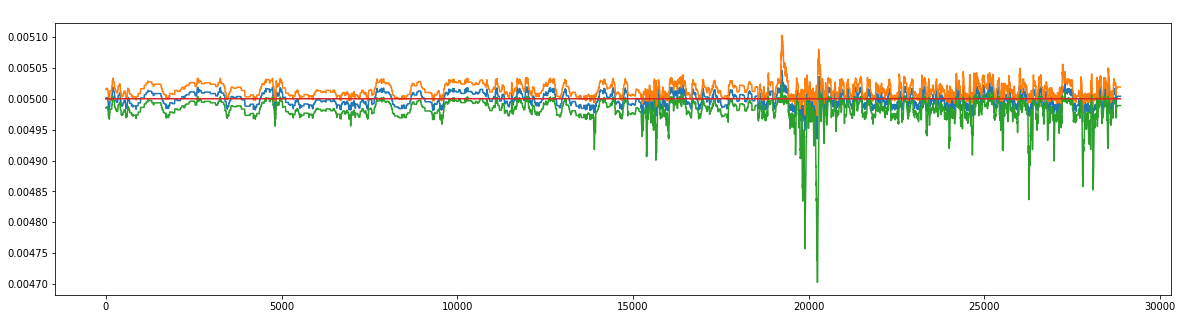

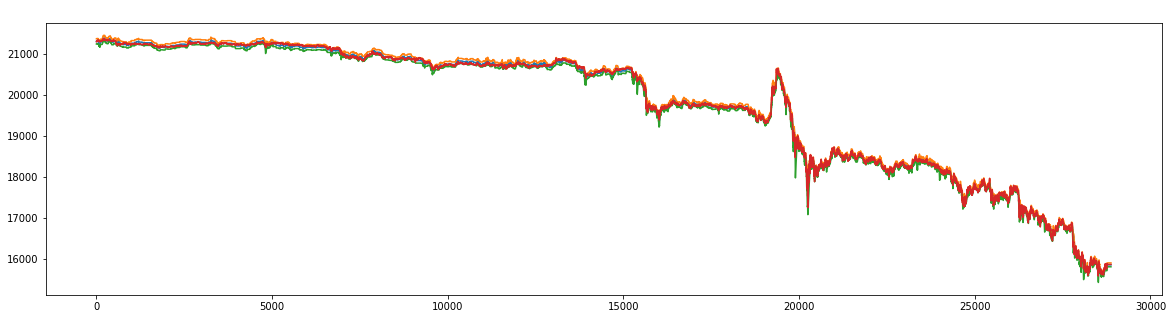

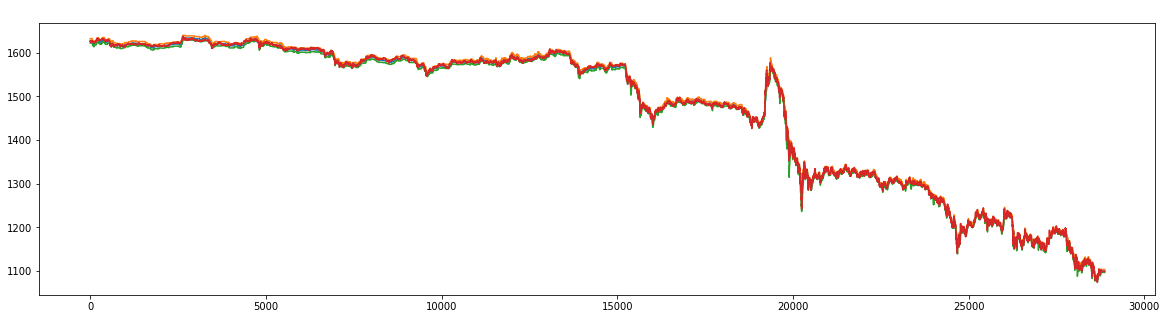

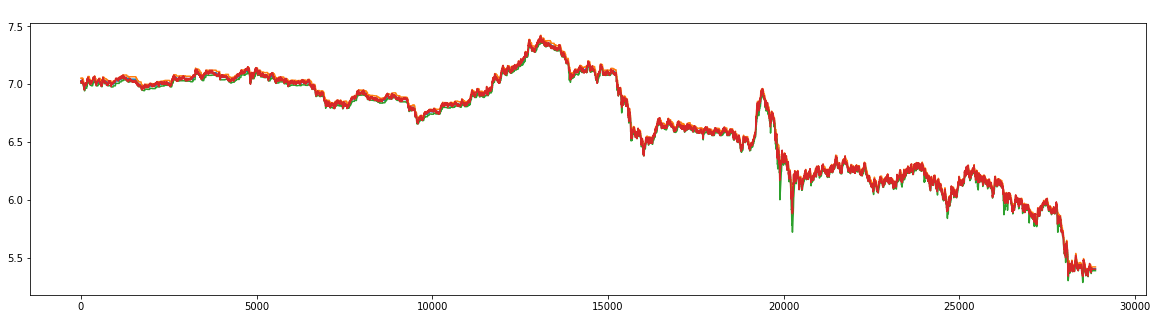

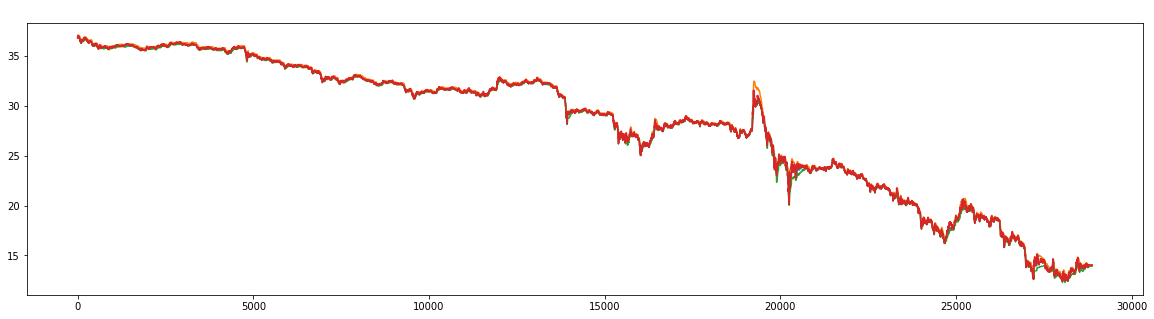

In [27]:
usd_index = -1
for i in range(len(initial_state.pools['omnipool'].asset_list)):
    if initial_state.pools['omnipool'].asset_list[i] == "USD":
        usd_index = i
        break

# get USD fees
USD_fees = [None]*len(events)
USD_lrna_fees = [None]*len(events)
for i in range(len(events)):
    op = events[i]['state'].pools['omnipool']
    USD_fees[i] = op.last_fee['USD']
    USD_lrna_fees[i] = op.last_lrna_fee['USD']


for tkn in initial_state.pools['omnipool'].asset_list:
    if tkn == 'USD':
        continue
    prices = [None]*len(events)
    last_fees = [None]*len(events)
    last_lrna_fees = [None]*len(events)
    buy_prices = [None]*len(events)
    sell_prices = [None]*len(events)
    market_prices = [None]*len(events)
    for i in range(len(events)):
        op = events[i]['state'].pools['omnipool']
        market_prices[i] = events[i]['state'].external_market[tkn]
        prices[i] = op.usd_price(tkn)
        last_fees[i] = op.last_fee[tkn]
        last_lrna_fees[i] = op.last_lrna_fee[tkn]
        buy_prices[i] = prices[i] / (1 - last_fees[i]) / (1 - USD_lrna_fees[i])
        sell_prices[i] = prices[i] * (1 - USD_fees[i]) * (1 - last_lrna_fees[i])

    ax = pu.plot(prices)
    ax = pu.plot(buy_prices, subplot=ax)
    ax = pu.plot(sell_prices, subplot=ax)
    pprint(tkn)
    pu.plot(market_prices, subplot=ax)


In [25]:
market = events[0]['state'].external_market
print(market)

{'HDX': 0.005, 'USD': 1, 'BTC': 21296.04, 'ETH': 1626.28, 'DOT': 7.02, 'SOL': 36.84}


:::FEES:::


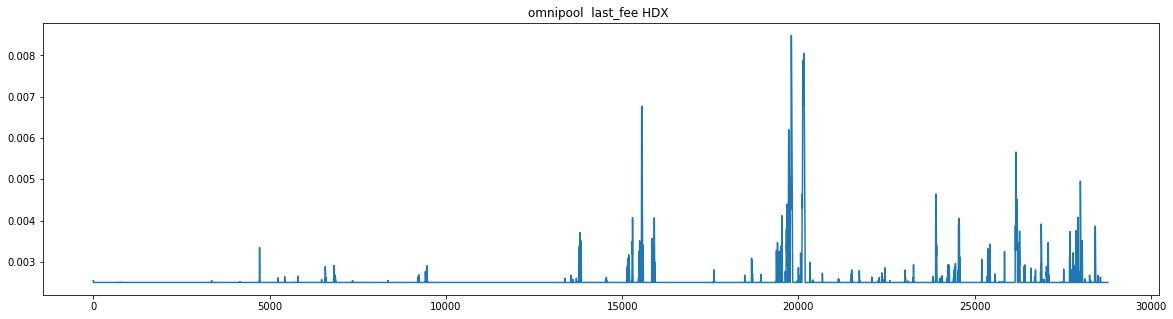

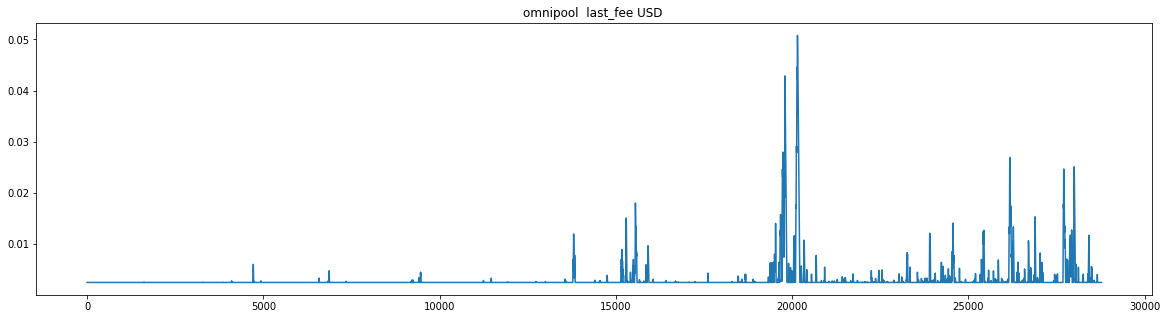

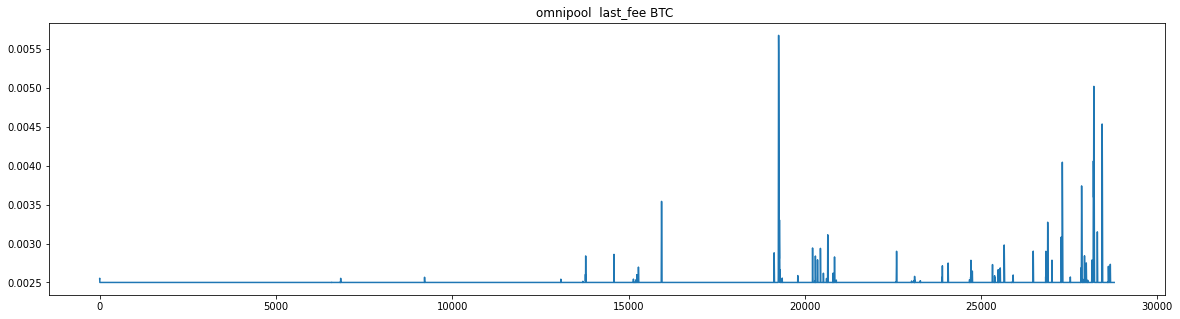

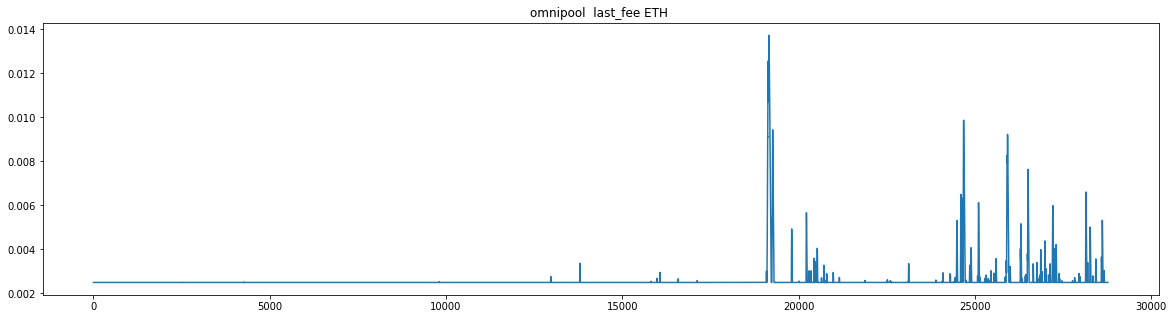

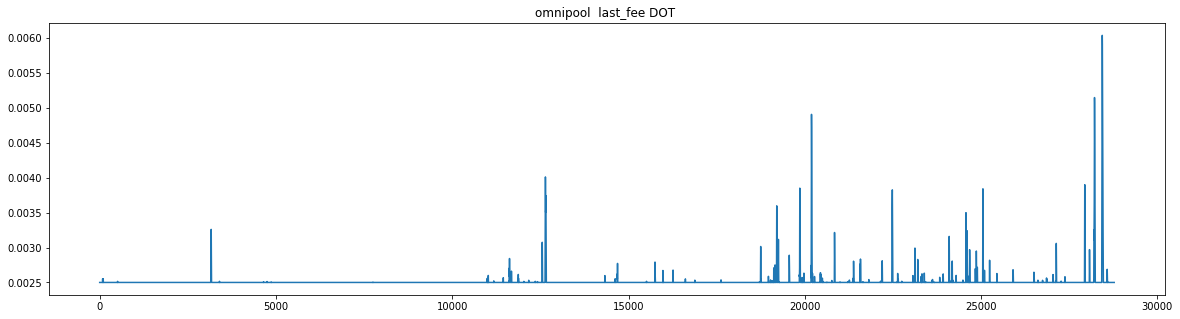

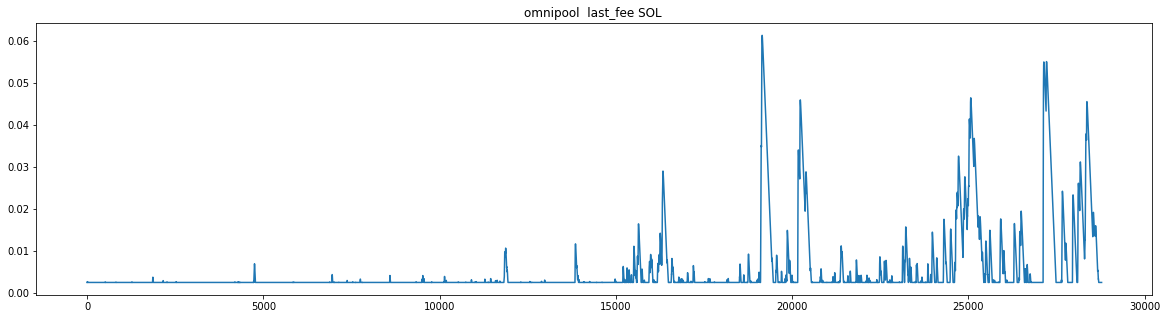

In [4]:
# print(events[0])
# dynamic_mult = [events[i]['state'].pools['omnipool'].last_mult for i in range(len(events))]
# plt.plot(range(len(dynamic_mult)), dynamic_mult)
# print(initial_state.pools['omnipool'].asset_list)
print(":::FEES:::")
# asset_fee = pu.get_datastream(events, pool='omnipool', prop='asset_fee', key='all')  # {tkn: [event['asset_fee'][tkn] for event in events[10:]] for tkn in assets}
# lrna_fee = pu.get_datastream(events, pool='omnipool', prop='lrna_fee', key='all')  # {tkn: [event['lrna_fee'][tkn] for event in events[10:]] for tkn in assets}
# print(lrna_fee['HDX'][1])
for tkn in initial_state.pools['omnipool'].asset_list:
    # print(tkn)
    # plt.figure(figsize=(20, 5))
    # ax = pu.plot(events[10:], pool='omnipool', prop='last_lrna_fee', key=tkn)
    pu.plot(events[100:], pool='omnipool', prop='last_fee', key=tkn)
    # plt.title(tkn)

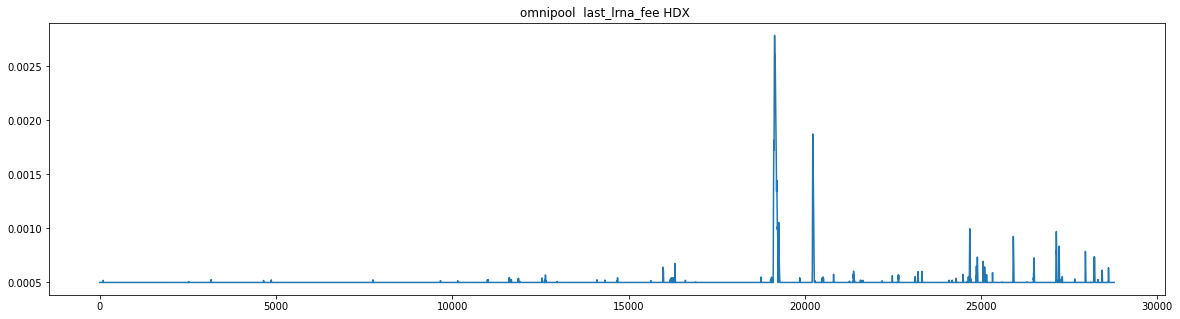

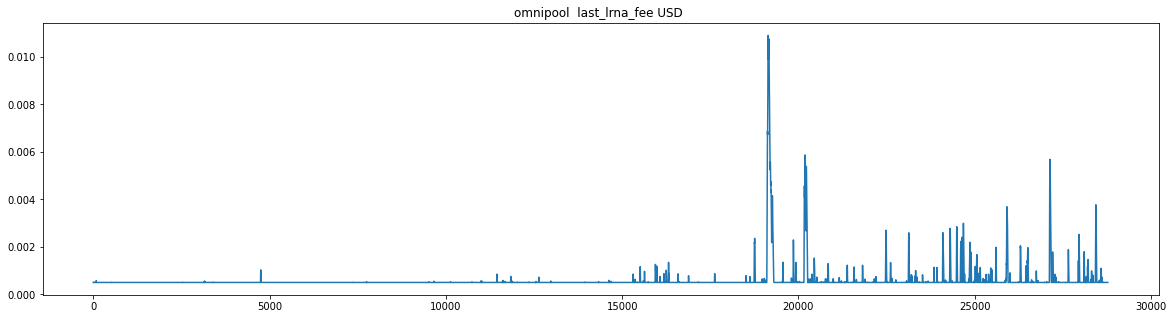

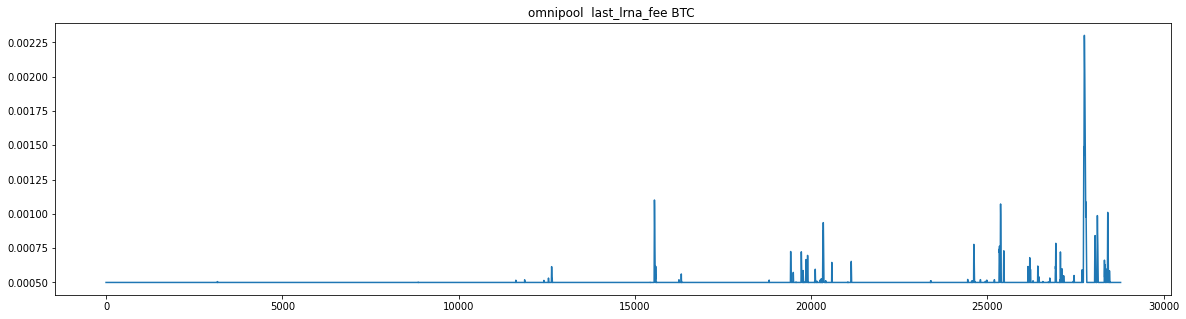

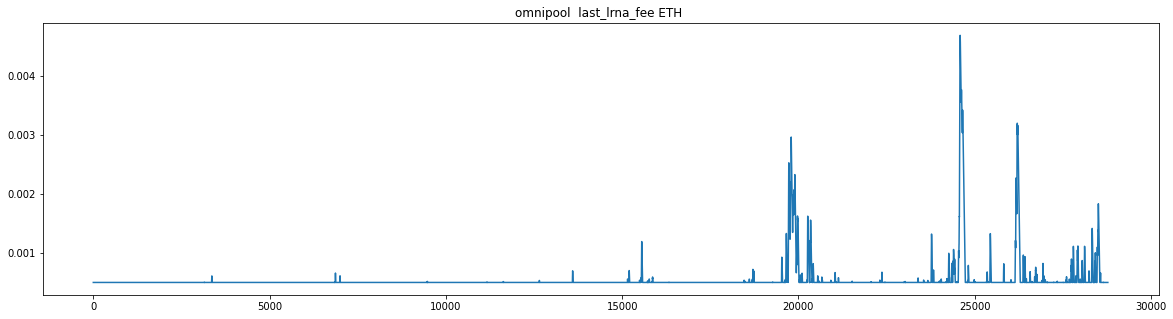

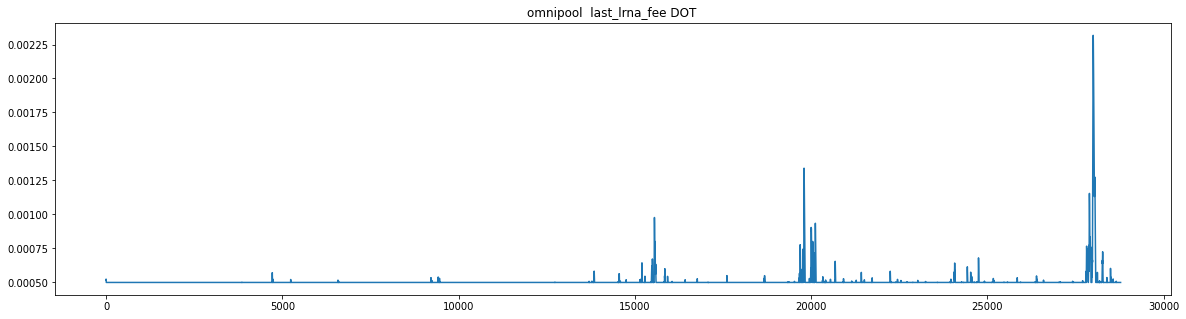

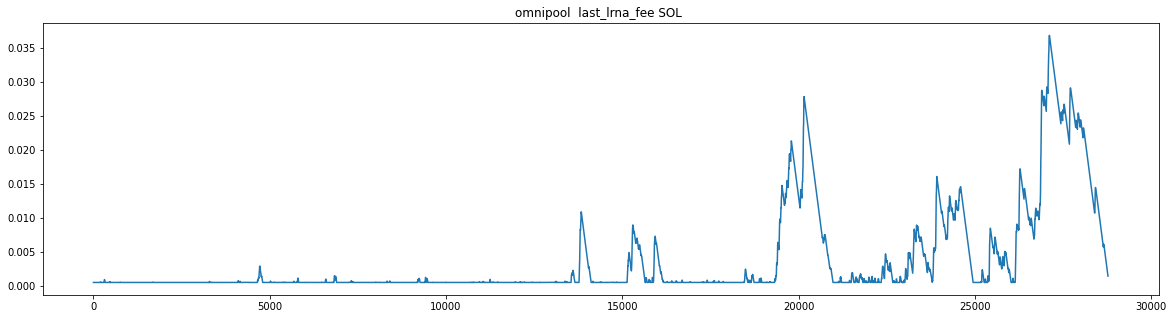

In [5]:
for tkn in initial_state.pools['omnipool'].asset_list:
    pu.plot(events[100:], pool='omnipool', prop='last_lrna_fee', key=tkn)

In [6]:
basic_state = initial_state.copy()
basic_state.pools['omnipool'].lrna_fee = 0.0005
basic_state.pools['omnipool'].asset_fee = 0.0025

events2 = run.run(basic_state, time_steps=time_steps)
# events2 = processing.postprocessing(events2, optional_params=['withdraw_val'])

# print(events2[-1])
# feeless_arbitrageur = events2[-1]['state'].agents['Arbitrageur']

Starting simulation...
Execution time: 133.489 seconds.


<AxesSubplot:title={'center':'  '}>

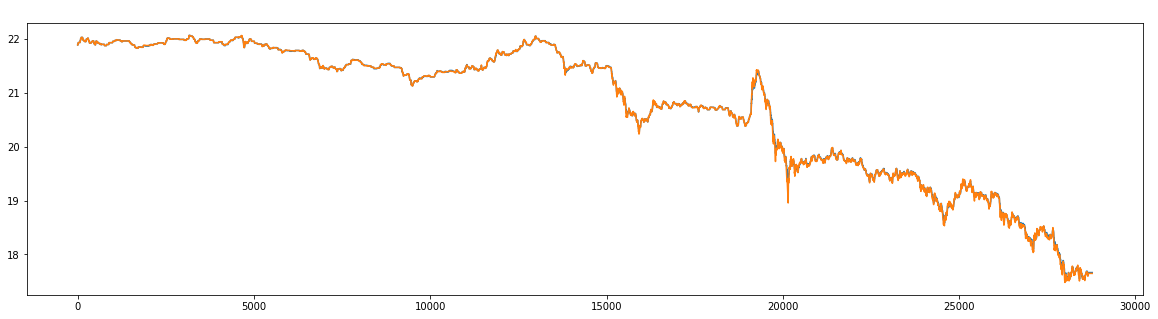

In [7]:
# for tkn in initial_state.pools['omnipool'].asset_list:
#     # print(tkn)
#     # plt.figure(figsize=(20, 5))
#     ax = pu.plot(events[100:], pool='omnipool', prop='price', key=tkn)
#     pu.plot(events2[100:], pool='omnipool', prop='price', key=tkn, subplot=ax)
#     # plt.title(tkn)

lrna_prices = [1/event['state'].pools['omnipool'].price("USD") for event in events[100:]]
lrna_prices2 = [1/event['state'].pools['omnipool'].price("USD") for event in events2[100:]]
ax = pu.plot(lrna_prices)
pu.plot(lrna_prices2, subplot=ax)

Text(0.5, 1.0, 'LPETH with dynamic fees (blue) vs 0.25% flat (orange)')

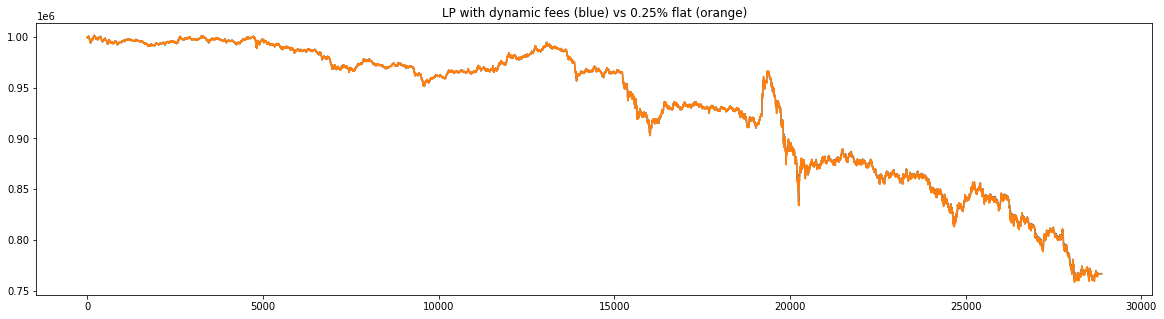

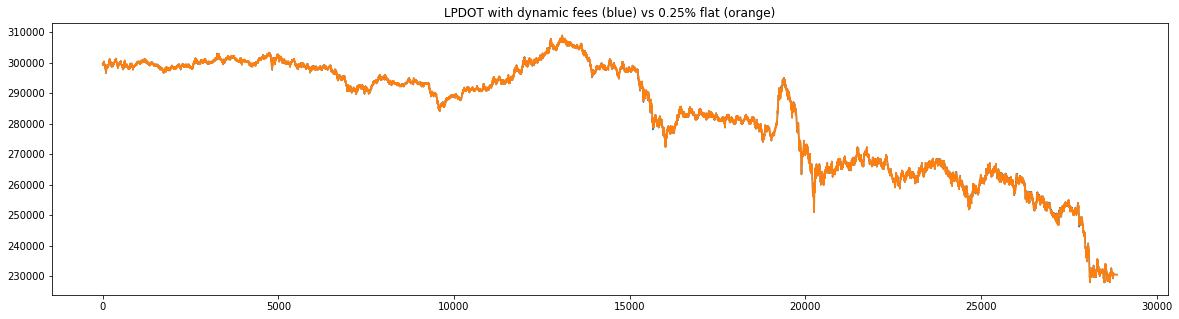

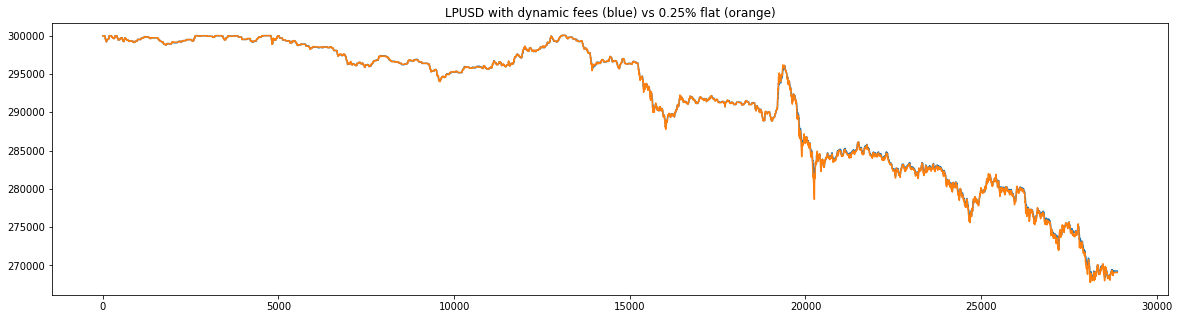

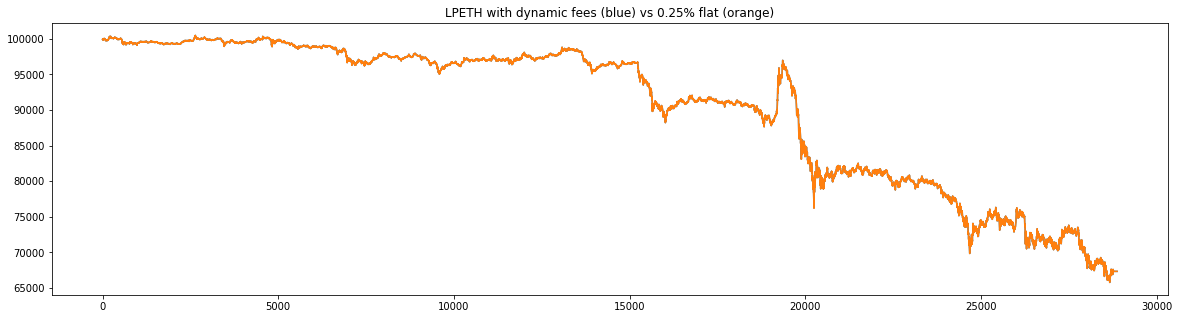

In [8]:
# lp_with_fees = pu.get_datastream(events, 'LP returns')
# lp_no_fees = pu.get_datastream(events2, 'LP returns')
# import cProfile, pstats
# profiler = cProfile.Profile()
# profiler.enable()

ax = pu.plot(events, agent='LP', prop='cash_out')
pu.plot(events2, agent='LP', prop='cash_out', subplot=ax)
plt.title('LP with dynamic fees (blue) vs 0.25% flat (orange)')





ax = pu.plot(events, agent='LPDOT', prop='cash_out')
pu.plot(events2, agent='LPDOT', prop='cash_out', subplot=ax)
plt.title('LPDOT with dynamic fees (blue) vs 0.25% flat (orange)')

# lp_cashout = state.cash_out(state.agents['LPDOT'])

ax = pu.plot(events, agent='LPUSD', prop='cash_out')
pu.plot(events2, agent='LPUSD', prop='cash_out', subplot=ax)
plt.title('LPUSD with dynamic fees (blue) vs 0.25% flat (orange)')

ax = pu.plot(events, agent='LPETH', prop='cash_out')
pu.plot(events2, agent='LPETH', prop='cash_out', subplot=ax)
plt.title('LPETH with dynamic fees (blue) vs 0.25% flat (orange)')

# profiler.disable()
# stats = pstats.Stats(profiler)
# stats.dump_stats('profile-data')



In [9]:
# lp_cashout = state.cash_out(state.agents['LPDOT'])


# lrna_imbalance = [event['state'].pools['omnipool'].lrna_imbalance for event in events]
pprint(events[0]['state'].cash_out(events[0]['state'].agents['LPUSD']))
pprint(events[-1]['state'].cash_out(events[-1]['state'].agents['LPUSD']))
pprint(events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPUSD']))
savings = events[-1]['state'].cash_out(events[-1]['state'].agents['LPUSD']) - events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPUSD'])
pprint(savings/events[0]['state'].cash_out(events[0]['state'].agents['LPUSD']))

pprint(events[0]['state'].cash_out(events[0]['state'].agents['LPETH']))
pprint(events[-1]['state'].cash_out(events[-1]['state'].agents['LPETH']))
pprint(events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPETH']))
savings = events[-1]['state'].cash_out(events[-1]['state'].agents['LPETH']) - events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPETH'])
pprint(savings/events[0]['state'].cash_out(events[0]['state'].agents['LPETH']))

mpf('300000.0000000000000000000000000000000000000000000007')
mpf('269249.57671816994839952614014851183148871278740206008')
mpf('269060.59516092440309722279691397775227945488484239189')
mpf('0.00062993852415181767434447744844693069752634186556060778')
mpf('99938.547760680409906395034715365531021167758288427775')
mpf('67319.185829200791121359329183402097098264282884108412')
mpf('67322.714415002492916060875424011334432034425586744147')
mpf('-0.000035307555300399044853493662406884393181009884295681405')


In [10]:
# pprint(events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPDOT']))
init_omni = events[1]['state'].pools['omnipool']
final_omni = events[-1]['state'].pools['omnipool']
init_omni2 = events2[1]['state'].pools['omnipool']
final_omni2 = events2[-1]['state'].pools['omnipool']

pprint(events[-1]['state'].cash_out(events[-1]['state'].agents['LPDOT']))
pprint(events[-1]['state'].agents['LPDOT'].holdings[('omnipool', 'DOT')])
pprint(events[-1]['state'].agents['LPDOT'].share_prices[('omnipool', 'DOT')])
print(events[0]['state'].pools['omnipool'].price('DOT'))
print(events[-1]['state'].pools['omnipool'].price('DOT'))
print(events2[-1]['state'].pools['omnipool'].price('DOT'))
print(events[0]['state'].pools['omnipool'].price('USD'))
print(events[-1]['state'].pools['omnipool'].price('USD'))
print(events2[-1]['state'].pools['omnipool'].price('USD'))
print(events[0]['state'].pools['omnipool'].price('DOT')/events[0]['state'].pools['omnipool'].price('USD'))
print(events[-1]['state'].pools['omnipool'].price('DOT')/events[-1]['state'].pools['omnipool'].price('USD'))
print(events2[-1]['state'].pools['omnipool'].price('DOT')/events2[-1]['state'].pools['omnipool'].price('USD'))
print(init_omni.liquidity['DOT'])
print(final_omni.liquidity['DOT'])
print(final_omni2.liquidity['DOT'])
print(init_omni.lrna['DOT'])
print(final_omni.lrna['DOT'])
print(final_omni2.lrna['DOT'])
print(init_omni.lrna_total)
print(final_omni.lrna_total)
print(final_omni2.lrna_total)
pprint(init_omni.lrna)
pprint(final_omni.lrna)
pprint(final_omni2.lrna)

pprint(events[0]['state'].agents['Arbitrageur'].holdings['LRNA'])
pprint(events[-1]['state'].agents['Arbitrageur'].holdings['LRNA'])
pprint(events2[-1]['state'].agents['Arbitrageur'].holdings['LRNA'])


# pprint(events2[0]['state'].agents['LPDOT'])
# pprint(events2[-1]['state'].agents['LPDOT'])
# pprint(events[0]['state'].agents['LPDOT'])
# pprint(events[-1]['state'].agents['LPDOT'])
# state.cash_out(state.agents['LPDOT'])


mpf('230498.38211011709178796843663019546367791239437833888')
mpf('42674.253008614909908249297204606241518985726949836011')
mpf('0.31954545310809951539280702105012154778903179608188478')
0.31954545310809951539280702105012154778903179608188
0.30590781361108339960751309775683348864394026375726
0.30617324851895130333897580482211902011988544917062
0.045454545250085275647626861920042140970601049521307
0.056611788489398691548111470211396384572440423795258
0.056662899458999925000049803192542268239317916290863
7.0300000000000006069797867288192637315185069891493
5.4036062412755021177934466509342528709354390853012
5.4034165466681031211320191177581037689806359204698
512091.04262981754582449364934580109140736068669327
523636.20741691048758593878976487378349601164271451
523429.22105132572524116345915406659798686127210144
163636.36351368751844172867833976942520736062971264
160184.4073385068602600887100270891817105018981129
160260.02497902864847333295605272565037027501545176
531818.181470599500835678

In [11]:
# print(events[0], events[1000])

In [12]:
print(processing.cash_out(events[0]['state'], events[-1]['state'].agents['LP']))
print(processing.cash_out(events[-1]['state'], events[-1]['state'].agents['LP']))
print(processing.cash_out(events2[-1]['state'], events2[-1]['state'].agents['LP']))

999330.04878099547510724054737998728765689456126202
766922.96402787089360361930399378228092573293041325
766573.16766959835015912877071134769332513951451411


In [13]:
print(processing.cash_out(events[0]['state'], events[-1]['state'].agents['LPDOT']))
print(processing.cash_out(events[-1]['state'], events[-1]['state'].agents['LPDOT']))
print(processing.cash_out(events2[-1]['state'], events2[-1]['state'].agents['LPDOT']))

299573.25746799426604088131374127228321482441946756
230498.38211011709178796843663019546367791239437834
230509.36717317743057234064797383671930008235498413


In [14]:
print(processing.cash_out(events[0]['state'], events[-1]['state'].agents['LPUSD']))
print(processing.cash_out(events[-1]['state'], events[-1]['state'].agents['LPUSD']))
print(processing.cash_out(events2[-1]['state'], events2[-1]['state'].agents['LPUSD']))

300000.0
269249.57671816994839952614014851183148871278740206
269060.59516092440309722279691397775227945488484239


In [15]:
print(events[-1]['state'].agents['LPDOT'].holdings[('omnipool', 'DOT')])
print(events2[-1]['state'].agents['LPDOT'].holdings[('omnipool', 'DOT')])
print(events[0]['state'].pools['omnipool'].price('DOT')/events[0]['state'].pools['omnipool'].price('USD'))
print(events[-1]['state'].pools['omnipool'].price('DOT')/events[-1]['state'].pools['omnipool'].price('USD'))
print(events2[-1]['state'].pools['omnipool'].price('DOT')/events2[-1]['state'].pools['omnipool'].price('USD'))
# print(events[-1]['state'].agents['LPAUSD'])

42674.253008614909908249297204606241518985726949836
42674.253008614909908249297204606241518985726949836
7.0300000000000006069797867288192637315185069891493
5.4036062412755021177934466509342528709354390853012
5.4034165466681031211320191177581037689806359204698


<AxesSubplot:title={'center':'omnipool  price USD '}>

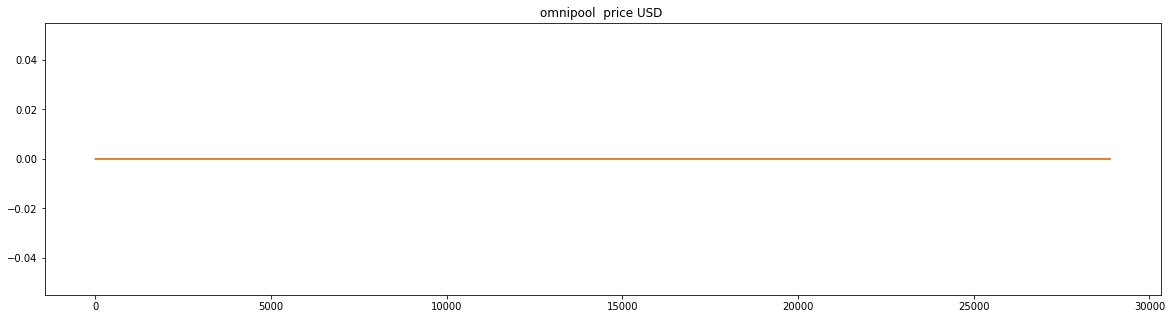

In [16]:
ax = pu.plot(events, pool='omnipool', prop='price', key='USD')
pu.plot(events2, pool='omnipool', prop='price', key='USD', subplot=ax)

In [17]:
final_pool1 = events[-1]['state'].pools['omnipool']
final_pool2 = events2[-1]['state'].pools['omnipool']
lrna_price1 = 1/events[-1]['state'].pools['omnipool'].price('USD')
print(lrna_price1)
lrna_price2 = 1/events2[-1]['state'].pools['omnipool'].price('USD')
print(lrna_price2)
total_lrna1 = sum(events[-1]['state'].pools['omnipool'].lrna[tkn] for tkn in events[-1]['state'].pools['omnipool'].asset_list)
print(total_lrna1)
total_lrna2 = sum(events2[-1]['state'].pools['omnipool'].lrna[tkn] for tkn in events2[-1]['state'].pools['omnipool'].asset_list)
print(total_lrna2)
print(lrna_price1*total_lrna1)
print(lrna_price2*total_lrna2)
print(final_pool1.lrna_imbalance) # dynamic fees cause us to burn a lot more LRNA!
print(final_pool2.lrna_imbalance)

17.664165480079529139050689444898798298474247506058
17.64823208038584116071127948944651907893551735746
531818.18147060471404210586255673610679165041679632
531818.1814706042406172557966937453932738208321652
9394124.3628117264666116981590032656999566758448373
9385650.6911619766806714725634719840948791906987322
0.0
0.0


In [18]:
print(initial_state)

global state 
pools: 

    Omnipool: omnipool
    ********************************
    tvl cap: inf
    lrna fee:
    
        HDX: Dynamic LRNA fee (oracle=fee_raise, amplification=0.2, min=0.0005)
        USD: Dynamic LRNA fee (oracle=fee_raise, amplification=0.2, min=0.0005)
        BTC: Dynamic LRNA fee (oracle=fee_raise, amplification=0.2, min=0.0005)
        ETH: Dynamic LRNA fee (oracle=fee_raise, amplification=0.2, min=0.0005)
        DOT: Dynamic LRNA fee (oracle=fee_raise, amplification=0.2, min=0.0005)
        SOL: Dynamic LRNA fee (oracle=fee_raise, amplification=0.2, min=0.0005)
    
    asset fee:
    
        HDX: Dynamic fee (oracle=fee_raise, amplification=1, min=0.0025)
        USD: Dynamic fee (oracle=fee_raise, amplification=1, min=0.0025)
        BTC: Dynamic fee (oracle=fee_raise, amplification=1, min=0.0025)
        ETH: Dynamic fee (oracle=fee_raise, amplification=1, min=0.0025)
        DOT: Dynamic fee (oracle=fee_raise, amplification=1, min=0.0025)
        SOL

In [19]:
pprint(events[0]['state'].pools['omnipool'].liquidity)
pprint(events[0]['state'].agents['Trader'].holdings)
pprint(events[-1]['state'].agents['Trader'].holdings)

{'BTC': mpf('51.642901753517070046266725862234159185403104299035457'),
 'DOT': mpf('512091.04032636860943050200089077536001170123022968021'),
 'ETH': mpf('737.42687459940760287955889254993226248407279769492489'),
 'HDX': mpf('220000000.89962477567502263395337029761981791168740117'),
 'SOL': mpf('29810.298224881408223803330142830395274030779738112509'),
 'USD': mpf('3600000.0134943716351253395093005544642972686753080152')}
{'AUSD': 1000000000,
 'BTC': mpf('999999999.99999978882166493075561503733202926922488682'),
 'DOT': mpf('999999999.99808045922686695044890780862436329876977048'),
 'ETH': mpf('999999999.9999972358021493688156780768332270941742725'),
 'HDX': mpf('999999999.10037522432497736604662970238018208831259883'),
 'LRNA': mpf('1000000000.0'),
 'R1': 1000000000,
 'R2': 3000000000,
 'SOL': mpf('999999999.99987809962389227334603216788811219968901146'),
 'USD': mpf('999999999.98650562836487466049069944553570273132469159')}
{'AUSD': 1000000000,
 'BTC': mpf('999999999.9931962437888755